## Análisis de la variable "churn_percentage" utilizando regresión lineal

Este notebook tiene como objetivo construir un modelo de regresión lineal para predecir el **porcentaje de churn** en función de varias variables predictoras como:

- **PVP (Precio de Venta Promedio)**
- **Edad promedio del coche**
- **Kilómetros promedio en revisión**
- **Número promedio de revisiones**

A continuación, se explica cada uno de los pasos realizados:


In [449]:
# Importación de librerías necesarias

import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Ignorar las advertencias de tipo UserWarning

warnings.filterwarnings("ignore", category=UserWarning)

1. **Conexión a la base de datos y obtención de datos:**

   - Se establece una conexión a una base de datos SQL Server local utilizando `pyodbc`.
   - Se ejecuta una consulta SQL desde un archivo externo (`features_pvp.sql`) para obtener un conjunto de datos relacionado con el churn y las características de los vehículos.


In [450]:
# Parámetros de conexión a la base de datos SQL Server

LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Construcción de la cadena de conexión

local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"
conn = pyodbc.connect(local_conn_str)

In [451]:
# Lectura de la consulta SQL desde un archivo y ejecución en la base de datos

with open("../data/dwh/features_pvp.sql", "r") as file:
    query = file.read()

# Ejecución de la consulta SQL y carga de los resultados en un DataFrame

df = pd.read_sql_query(query, conn)


2. **Exploración inicial de los datos:**

   - Se verifica la existencia de valores nulos y duplicados en los datos.
   - Se generan histogramas para analizar la distribución de algunas variables importantes (`avg_car_age`, `avg_km_revision`, `avg_revisiones`, `churn_percentage`).


In [452]:
df.isnull().sum() # Comprobación de valores nulos

PVP                 0
avg_car_age         0
avg_km_revision     0
avg_revisiones      0
churn_percentage    0
dtype: int64

In [453]:
df.duplicated().sum() # Valores duplicados.

0

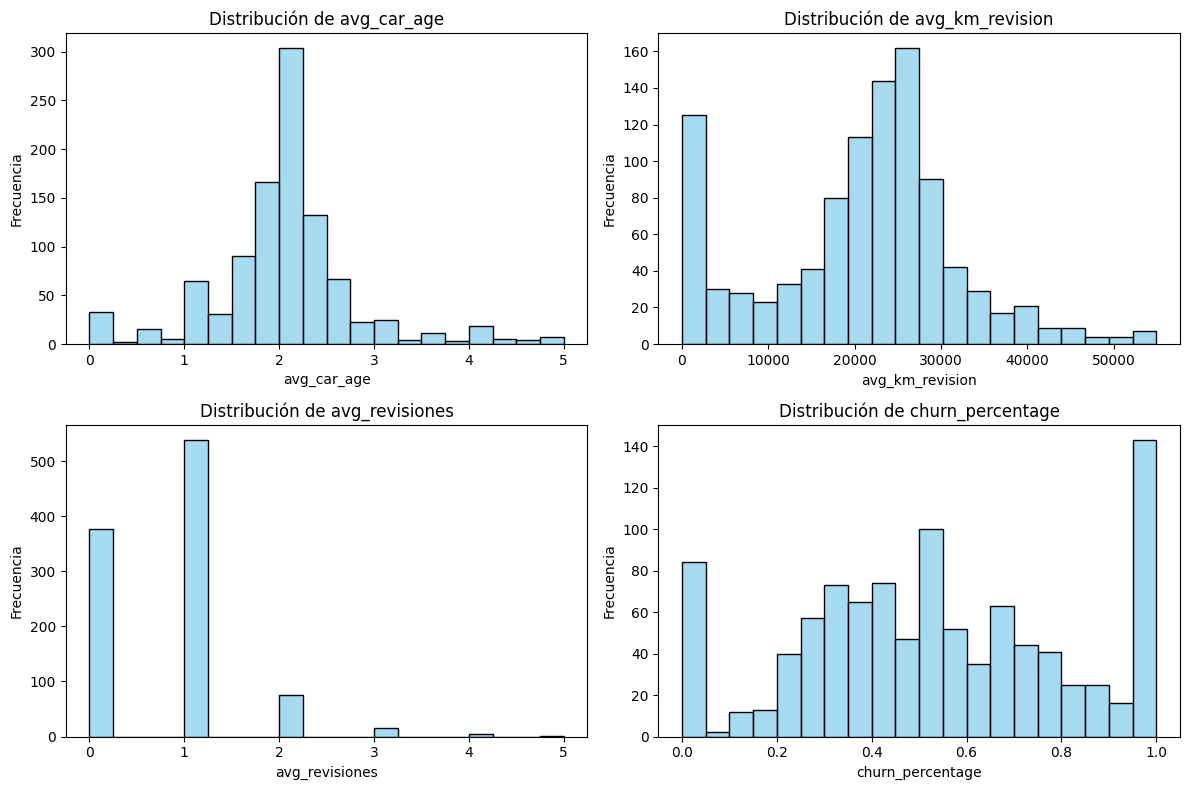

In [454]:
# Histograma sencillo de las variables numéricas seleccionadas
variables = ['avg_car_age', 'avg_km_revision', 'avg_revisiones', 'churn_percentage']
plt.figure(figsize=(12, 8))

for i, col in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    # Histograma básico con barras
    sns.histplot(df[col], kde=False, bins=20, color='skyblue')  # Sin KDE, solo histograma de barras
    plt.title(f'Distribución de {col}')  # Título sencillo
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


3. **Análisis de correlación y visualización de patrones:**

   - Se visualizan gráficos de dispersión entre las variables predictoras y la variable objetivo (`churn_percentage`) para observar posibles patrones lineales.
   - Se calcula y visualiza la **matriz de correlación** para evaluar las relaciones entre las variables.

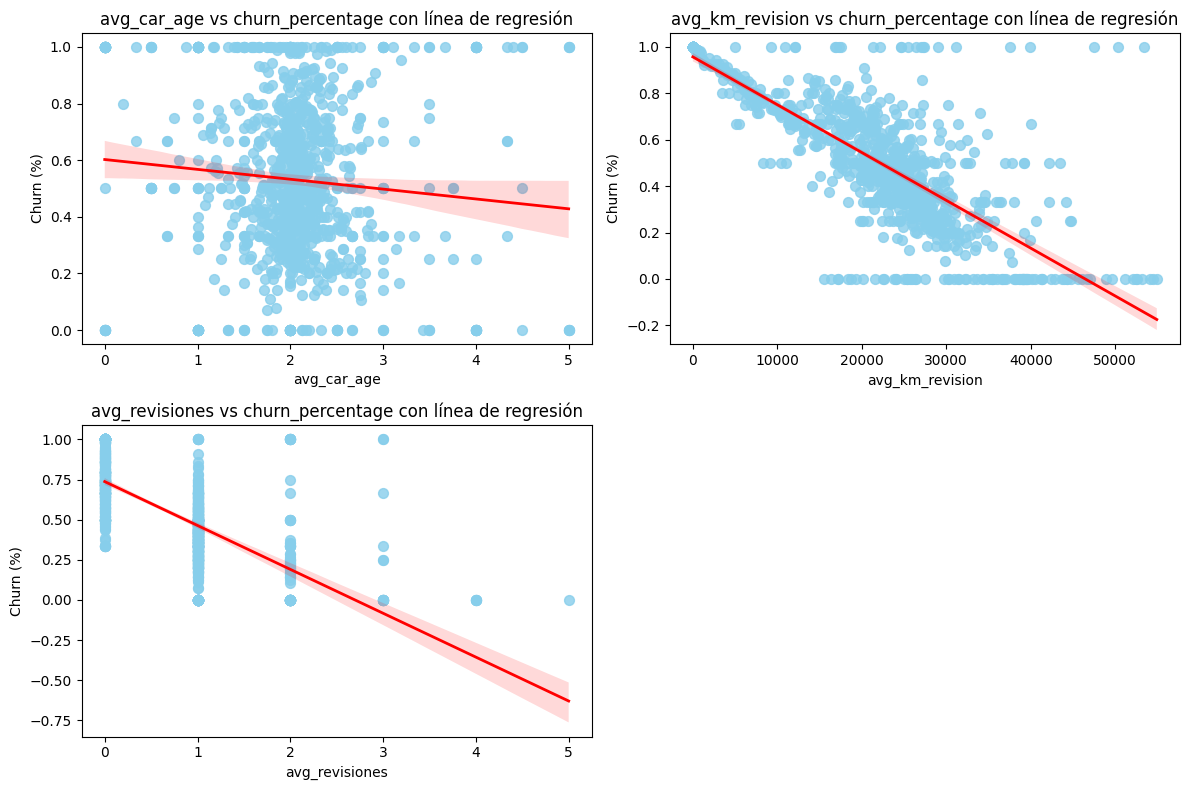

In [ ]:
# Gráficos de dispersión con líneas de regresión para observar patrones lineales
plt.figure(figsize=(12, 8))
for i, col in enumerate(['avg_car_age', 'avg_km_revision', 'avg_revisiones'], 1):
    plt.subplot(2, 2, i)
    sns.regplot(x=df[col], y=df['churn_percentage'], scatter_kws={'color': 'skyblue', 's': 50}, line_kws={'color': 'red', 'lw': 2})
    plt.title(f'{col} vs churn_percentage con línea de regresión')
    plt.xlabel(col)
    plt.ylabel('Churn (%)')
plt.tight_layout()
plt.show()


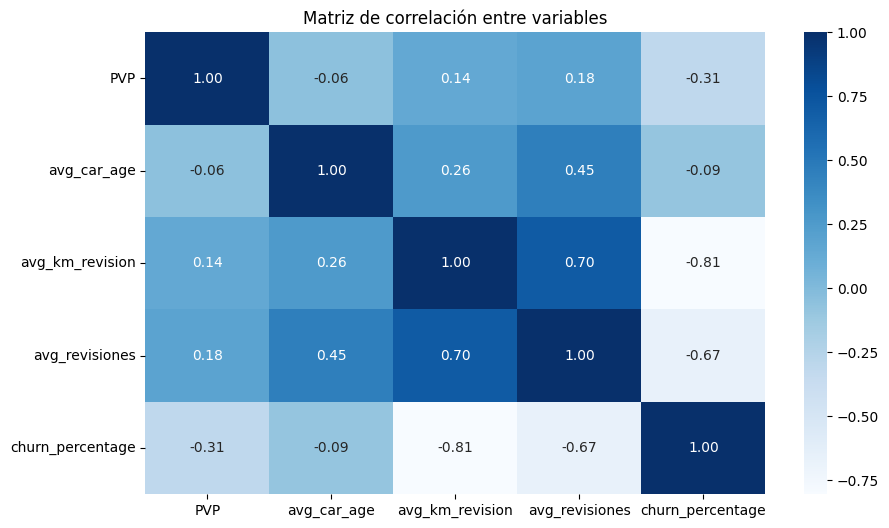

In [ ]:
# Matriz de correlación entre las variables numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

4. **Selección de características:**

   - Se utiliza el test de **f-regression** para evaluar la relación de cada variable predictora con la variable objetivo y obtener valores de significancia (`p-value`).


In [ ]:
# Análisis de la relación entre las variables predictoras y la variable objetivo utilizando f-regression

from sklearn.feature_selection import f_regression

X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

f_values, p_values = f_regression(X, y)
pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})


,Feature,F-value,p-value
0,PVP,110.079961,1.630309e-24
1,avg_car_age,8.414640,3.802924e-03
2,avg_km_revision,1864.716539,1.484917e-231
3,avg_revisiones,809.650412,3.123836e-131


5. **Modelo de regresión lineal:**

   - Se entrena un **modelo de regresión lineal** utilizando las variables predictoras seleccionadas.
   - Se predice el churn utilizando el modelo y se ajustan los valores predichos para que estén dentro del rango [0, 1].


In [458]:
# Definición de variables predictoras (X) y variable objetivo (y).
X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

In [ ]:
# Creación del modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

LinearRegression()

6. **Evaluación del modelo:**

   - Se calcula el **coeficiente de determinación R²** y el **error cuadrático medio (MSE)** para evaluar el rendimiento del modelo.
   - Se muestran los coeficientes estimados del modelo, los cuales indican la importancia de cada variable predictora en la predicción de churn.


In [ ]:
# Predicción del churn y ajuste de los valores predichos
y_pred = model.predict(X)
y_pred_clipped = np.clip(y_pred, 0, 1)

In [ ]:
# Evaluación del modelo usando R² y MSE
r2 = r2_score(y, y_pred_clipped)
mse = round(mean_squared_error(y, y_pred_clipped), 3)

# Mostrar las métricas de evaluación
metrics_df = pd.DataFrame({
    'Métrica': ['R² (coef. de determinación)', 'MSE (error cuadrático medio)'],
    'Valor': [r2, mse]
})

print("Evaluación del modelo:")
display(metrics_df)


Evaluación del modelo:


,Métrica,Valor
0,R² (coef. de determinación),0.736784
1,MSE (error cuadrático medio),0.022000


In [ ]:
# Mostrar los coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,-0.000008
1,avg_car_age,0.072755
2,avg_km_revision,-0.000016
3,avg_revisiones,-0.113550
4,Intercepto,0.997388


7. **Almacenamiento de coeficientes en la base de datos:**

   - Los coeficientes del modelo se almacenan en una tabla SQL para futuras consultas.

In [ ]:
# Guardar los coeficientes del modelo en la base de datos SQL Server
cursor = conn.cursor()
table = "churn_coef"

# Creación de la tabla.
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Vacio de la tabla antes de insertar nuevos coeficientes.
cursor.execute(f"DELETE FROM {table}")

# Inserción de coeficientes en la tabla.
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")

Tabla 'churn_coef' creada y poblada correctamente.


8. **Visualización de los resultados:**

   - Se genera un gráfico de dispersión para comparar el **churn real** frente al **churn predicho**, lo que permite evaluar visualmente la calidad de las predicciones.

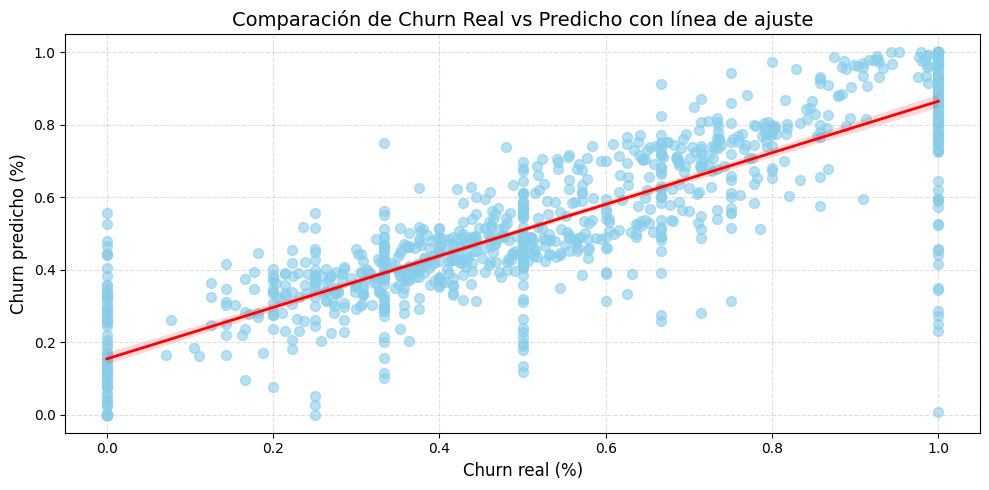

In [464]:
# Gráfico de dispersión comparando Churn Real vs Churn Predicho con línea de ajuste
plt.figure(figsize=(10, 5))
sns.regplot(x=y, y=y_pred_clipped, scatter_kws={'color': 'skyblue', 'alpha': 0.6, 's': 50}, line_kws={'color': 'red', 'lw': 2})

plt.xlabel("Churn real (%)", fontsize=12)
plt.ylabel("Churn predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho con línea de ajuste", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
